In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Grid search

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, get_scorer_names

# Tensorflow bundle

import tensorflow as tf

import pickle
#import smogn

In [2]:
data = pd.read_csv('patient_data_all_check_V11.csv', sep=';', index_col=0)


In [3]:
data.columns = data.columns.str.capitalize()

In [4]:
data.columns = data.columns.str.replace('Diastolic_presurre', 'Diastolic_pressure')

# Preprocess the data for some modelling

In [5]:
# Map data to English names for consistency

data['Sex'] = data['Sex'].map({"Kobieta": "F", "Mężczyzna": "M"})
data['Smoke'] = data['Smoke'].map({"Tak": 1, "Nie": 0})

# Remove Nans in Smoke_years and Smoke_amount_day columns

data['Smoke_years'] = data['Smoke_years'].fillna(0)
data['Smoke_amount_day'] = data['Smoke_amount_day'].fillna(0)

In [6]:
# Summarize data - check for nan values and so on

data.describe()

,Age,Weight_p,Height_p,Bmi,Smoke,Smoke_years,Smoke_amount_day,Chol_all,Ldl,Hdl,Sugar1,Sugar2,Sugar3,Systolic_pressure,Diastolic_pressure,Likelihood_of_obesity,Likelihood_of_diabetes,Likelihood_of_coronary_heart_disease
count,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000,11275.000000
mean,55.131353,75.146430,164.850466,27.791243,0.501197,8.135610,8.649933,173.412062,98.632727,67.155122,104.763991,101.922040,101.993703,126.312550,83.541197,0.594534,0.559896,0.458079
std,21.811863,16.660738,12.503581,6.175931,0.500021,8.883681,9.240116,49.759870,39.256531,10.097448,5.639367,6.070607,6.131784,10.436417,4.108382,0.173883,0.035682,0.095397
min,18.000000,40.000000,139.000000,13.060000,0.000000,0.000000,0.000000,125.000000,50.000000,40.000000,91.000000,91.000000,91.000000,106.000000,80.000000,0.340000,0.450000,0.300000
25%,36.000000,63.000000,156.000000,23.050000,0.000000,0.000000,0.000000,141.000000,72.000000,61.000000,101.000000,97.000000,97.000000,122.000000,81.000000,0.443000,0.536500,0.382000
50%,55.000000,75.000000,165.000000,27.460000,1.000000,5.000000,7.000000,152.000000,82.000000,68.000000,105.000000,102.000000,102.000000,124.000000,82.000000,0.571000,0.562000,0.461000
75%,74.000000,89.000000,174.000000,32.240000,1.000000,16.000000,17.000000,200.000000,110.000000,75.000000,109.000000,107.000000,107.000000,126.000000,84.000000,0.719000,0.575000,0.506000
max,92.000000,105.000000,191.000000,44.270000,1.000000,25.000000,25.000000,316.000000,213.000000,82.000000,114.000000,114.000000,114.000000,173.000000,98.000000,0.960000,0.820000,0.750000


In [7]:
data.head()

,Sex,Age,Weight_p,Height_p,Bmi,Smoke,Smoke_years,Smoke_amount_day,Chol_all,Ldl,Hdl,Sugar1,Sugar2,Sugar3,Systolic_pressure,Diastolic_pressure,Likelihood_of_obesity,Likelihood_of_diabetes,Likelihood_of_coronary_heart_disease
id,,,,,,,,,,,,,,,,,,,
0,F,45.0,49.0,165.0,18.00,0,0.0,0.0,176.0,87.0,72.0,100.0,111.0,114.0,119.0,84.0,0.403,0.571,0.442
1,M,41.0,105.0,158.0,42.06,0,0.0,0.0,147.0,73.0,73.0,105.0,92.0,91.0,121.0,83.0,0.935,0.521,0.391
2,F,26.0,54.0,180.0,16.67,1,19.0,22.0,138.0,54.0,60.0,103.0,96.0,97.0,121.0,84.0,0.362,0.544,0.328
3,M,72.0,102.0,159.0,40.35,0,0.0,0.0,304.0,162.0,55.0,108.0,97.0,103.0,125.0,81.0,0.929,0.569,0.643
4,F,69.0,87.0,155.0,36.21,1,16.0,16.0,158.0,73.0,64.0,96.0,93.0,104.0,125.0,82.0,0.911,0.510,0.488


# Data exploration
Plot distributions of some features

In [9]:
# Take a random sample of 1000 patients for plotting

data_sample = data.sample(n=1000, random_state=1)

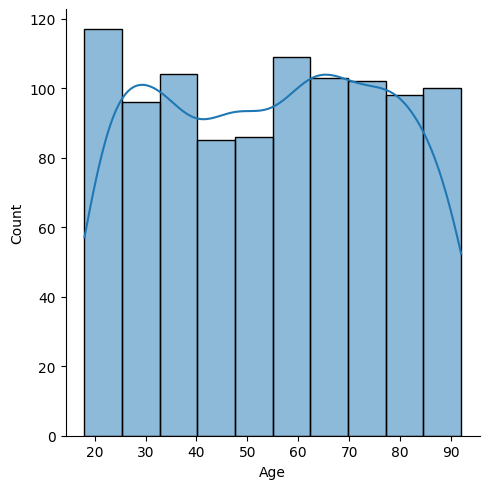

In [10]:
# Distribution of age

sns.displot(data_sample['Age'], kde=True, bins=10)

Ages are distributed almost uniformly.

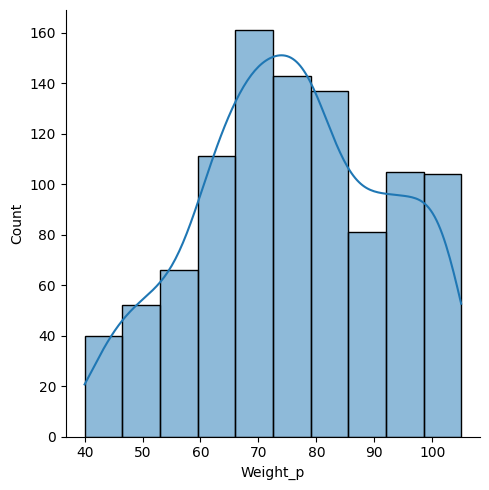

In [11]:
# Weight distribution

sns.displot(data_sample['Weight_p'], kde=True, bins=10)

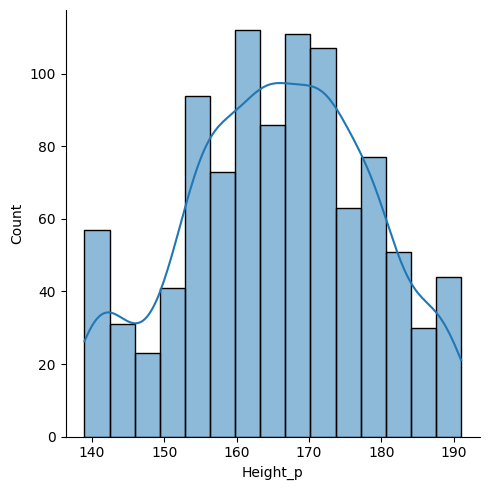

In [12]:
# Height distribution

sns.displot(data_sample['Height_p'], kde=True, bins=15)

Something's definitely wrong here. There can't be some overpopulation of 158cm tall (or rather short) people. Let's compare it to BMI, which should also contain this if it's true.

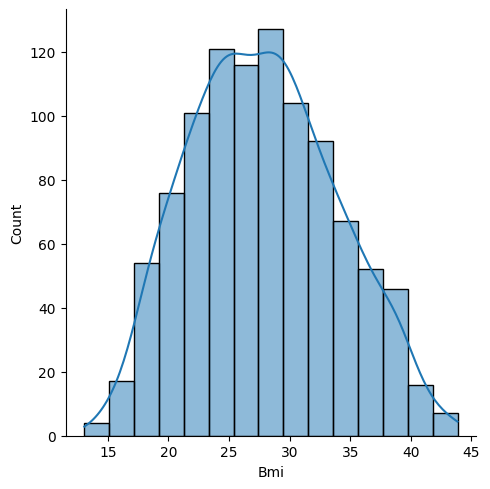

In [13]:
# BMI distribution

sns.displot(data_sample['Bmi'], kde=True, bins=15)

It's okay, I'd say linearly dependend on Weight. Let's see a pairplot.

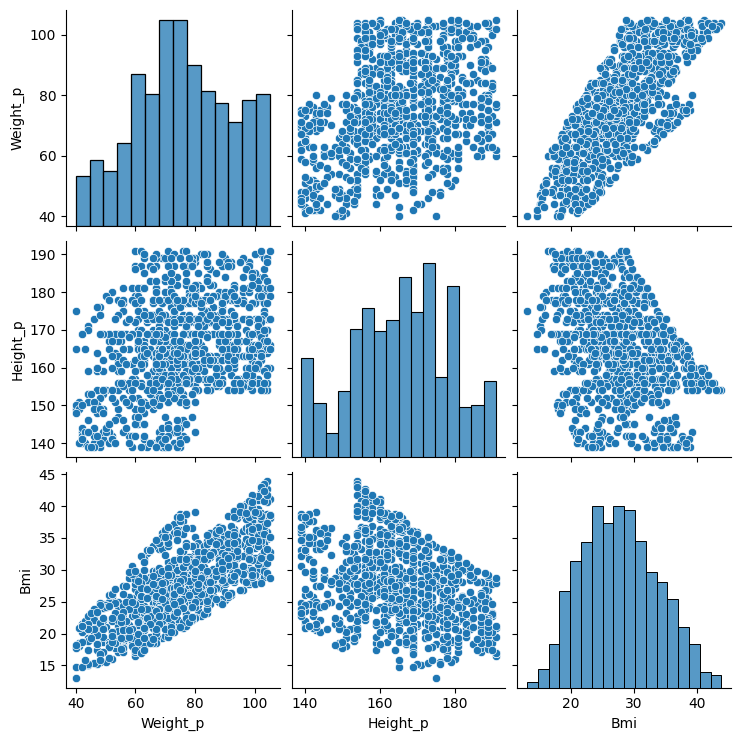

In [14]:
# Pairplot Weight, Height, BMI

sns.pairplot(data_sample[['Weight_p', 'Height_p', 'Bmi']])

There is definitely an error in the dataset. Need to report it to MW!

In [15]:
data['Height_p'].value_counts()

173.0    568
169.0    561
157.0    523
178.0    478
165.0    472
160.0    414
156.0    406
177.0    391
154.0    383
163.0    363
172.0    353
158.0    324
167.0    322
161.0    313
181.0    249
159.0    235
162.0    215
164.0    213
168.0    211
155.0    193
166.0    191
179.0    162
175.0    161
142.0    147
180.0    147
151.0    146
153.0    144
149.0    139
148.0    135
170.0    130
171.0    129
145.0    129
143.0    128
152.0    125
147.0    123
141.0    122
144.0    122
184.0    121
139.0    120
140.0    120
146.0    118
150.0    116
183.0    115
185.0    110
191.0    109
186.0    108
188.0    105
174.0    100
190.0     97
187.0     97
176.0     92
189.0     91
182.0     89
Name: Height_p, dtype: int64

Keep on with exploration of following quantitites

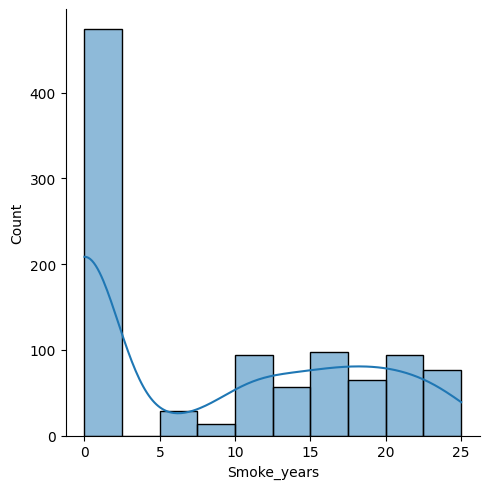

In [16]:
# Distribution of Smoking years

sns.displot(data_sample['Smoke_years'], kde=True, bins=10)

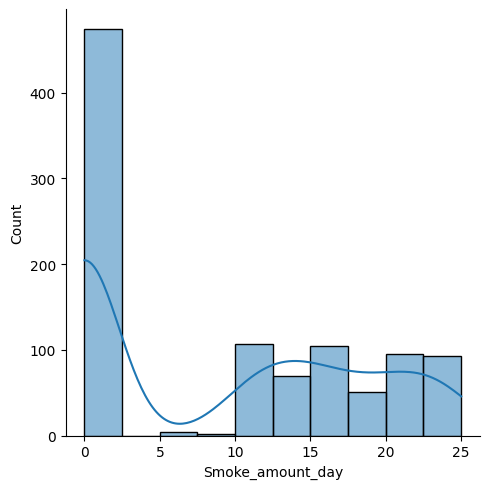

In [17]:
# Smoke amount per day


sns.displot(data_sample['Smoke_amount_day'], kde=True, bins=10)

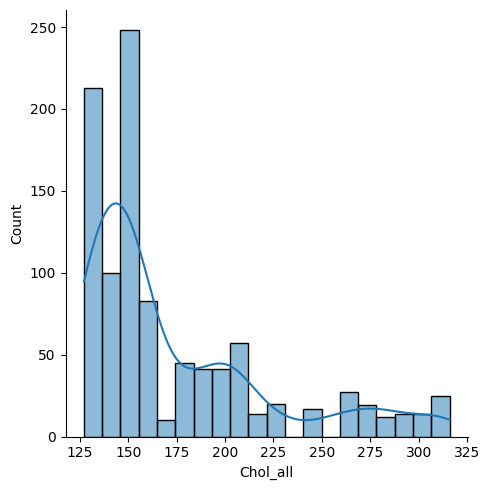

In [18]:
# Chol_all distribution

sns.displot(data_sample['Chol_all'], kde=True, bins=20)

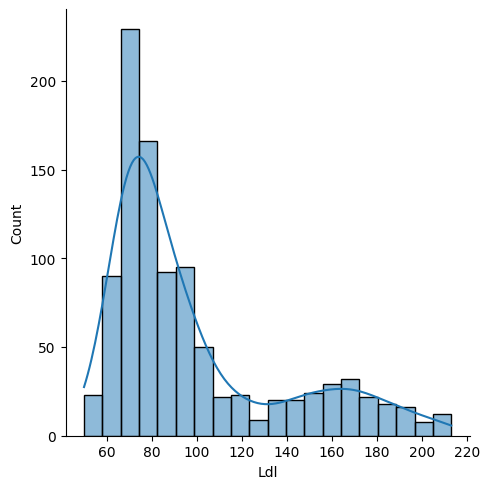

In [19]:
# Ldl distribution

sns.displot(data_sample['Ldl'], kde=True, bins=20)

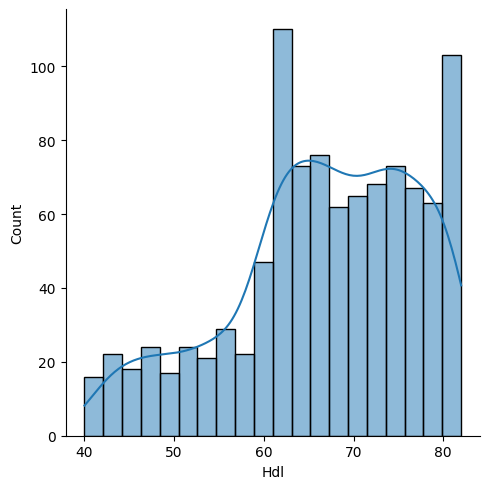

In [20]:
# Hdl distribution

sns.displot(data_sample['Hdl'], kde=True, bins=20)

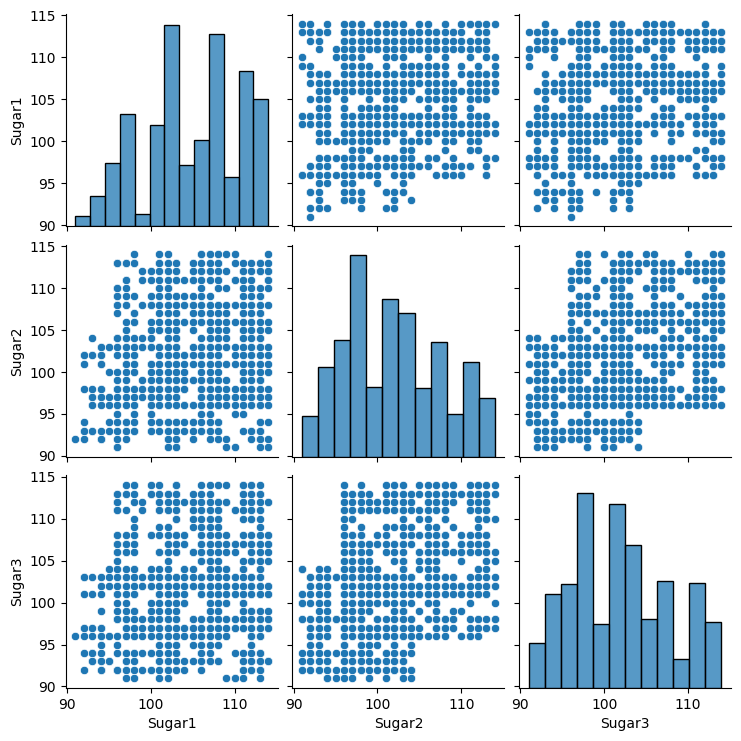

In [21]:
# Sugar distribution - pairplot for all 3 sugar columns

sns.pairplot(data_sample[['Sugar1', 'Sugar2', 'Sugar3']])

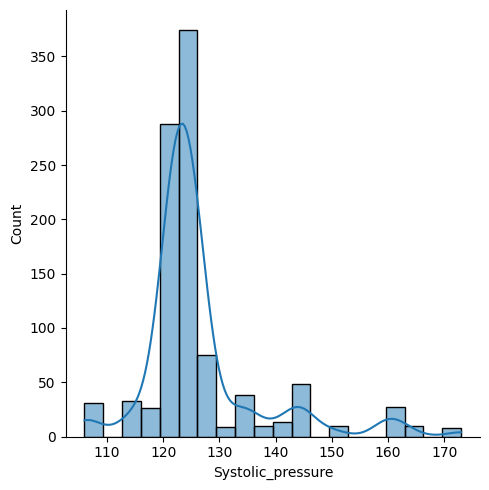

In [22]:
# Pressure distribution

sns.displot(data_sample['Systolic_pressure'], kde=True, bins=20)
plt.show()

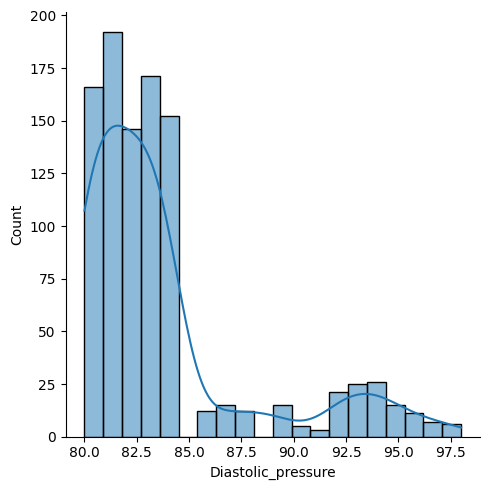

In [23]:
sns.displot(data_sample['Diastolic_pressure'], kde=True, bins=20)
plt.show()

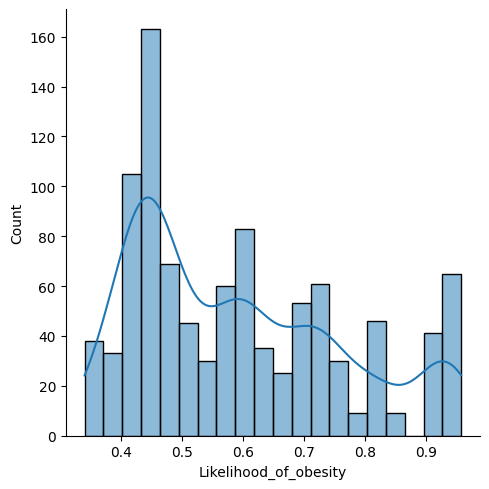

In [24]:
sns.displot(data_sample['Likelihood_of_obesity'], kde=True, bins=20)
plt.show()

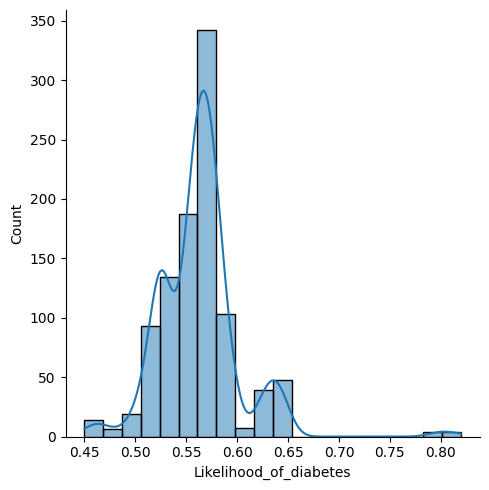

In [25]:
sns.displot(data_sample['Likelihood_of_diabetes'], kde=True, bins=20)
plt.show()

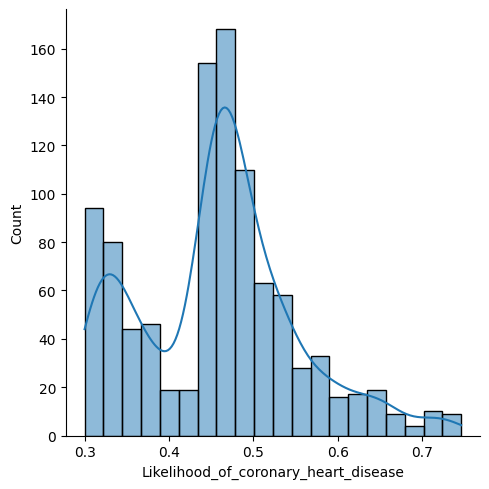

In [26]:
sns.displot(data_sample['Likelihood_of_coronary_heart_disease'], kde=True, bins=20)
plt.show()

# Feature extraction

In [7]:
# One hot encode sex and smoke columns

data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "M" else 0)

In [33]:
# X1 - without Smoke column - just years and amount per day
X1 = data[
    [
        'Sex', 
        'Age', 
        'Weight_p', 
        'Height_p', 
        'Bmi', 
        #'Smoke', 
        'Smoke_years', 
        'Smoke_amount_day', 
        'Chol_all', 
        'Ldl', 
        'Hdl', 
        'Sugar1', 
        'Sugar2', 
        'Sugar3', 
        'Systolic_pressure', 
        'Diastolic_pressure'
    ]
]



X1 = X1.to_numpy()

In [34]:
y_obes = data['Likelihood_of_obesity'].to_numpy()
y_diab = data['Likelihood_of_diabetes'].to_numpy()
y_chd = data['Likelihood_of_coronary_heart_disease'].to_numpy()

In [35]:
X1.shape

(11275, 15)

In [36]:
# Standardize data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale some X1 features
X1_scaled = scaler.fit_transform(X1[:, 1:])

# Concatenate scaled features with non-scaled features
X1_scaled = np.concatenate((X1[:, 0].reshape(-1, 1), X1_scaled), axis=1)



In [28]:
# Train test split



X_train, X_test, y_train, y_test = train_test_split(X1_scaled, y_obes, test_size=0.2, random_state=1)

# MODELLING

## 1. Obesity

In [48]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [38]:
# Let's try to use a simple linear regression model

print("--- Linear Regression ---")

linreg = LinearRegression()

linreg.fit(X_train, y_train)

# Predict on test set

y_pred = linreg.predict(X_test)

# Calculate RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))


--- Linear Regression ---
RMSE: 0.046368
R2: 0.928759


Not bad on such a simple model!!

In [39]:
# Let's go with a batch of models and see which one performs the best

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(),
    KNeighborsRegressor()
]

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(model)
    print("RMSE: %f" % (rmse))
    print("R2: %f" % (r2))
    print("")

LinearRegression()
RMSE: 0.046368
R2: 0.928759

Ridge()
RMSE: 0.046369
R2: 0.928755

Lasso()
RMSE: 0.173745
R2: -0.000276

DecisionTreeRegressor()
RMSE: 0.025908
R2: 0.977758

RandomForestRegressor()
RMSE: 0.018766
R2: 0.988331

SVR()
RMSE: 0.046737
R2: 0.927621

KNeighborsRegressor()
RMSE: 0.052833
R2: 0.907509



Trees seem (with RF included) perform exceptionally well. However let us give some chance to SVM with GridSearch.

In [49]:
# Grid search for best parameters for SVR

print("--- Grid Search ---")

svr = SVR()

parameters = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['auto'],
    'epsilon': [0.01, 0.1, 1]
}

grid = GridSearchCV(svr, parameters, cv=5, scoring='r2', verbose=2, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

--- Grid Search ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...........C=0.1, epsilon=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...........C=0.1, epsilon=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ........C=0.1, epsi

Unable to beat the tree. Let's try a different kind of tree - XGB

In [51]:
xgb = XGBRegressor()

parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

grid = GridSearchCV(xgb, parameters, cv=5, scoring='r2', verbose=2, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsa

R2 = 0.98916 - Super model!

In [53]:
best_params = grid.best_params_

# Reevaluate the model with the best parameters

xgb = XGBRegressor(**best_params)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))




RMSE: 0.018356
R2: 0.988835


In [54]:
# Save the model and the scaler

import pickle

pickle.dump(xgb, open('xgb_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

## 2. Diabetes

In [31]:
# Load specially prepared augumented data
data_aug = pd.read_csv('patient_data_diab_augumented.csv')

In [32]:
data_aug.head()

,sex,age,weight_p,height_p,BMI,Smoke,Smoke_Years,Smoke_amount_day,Chol_All,LDL,HDL,Sugar1,Sugar2,Sugar3,Systolic_pressure,Diastolic_presurre,Likelihood_of_diabetes
0,0.0,91.877923,87.389613,180.145458,26.927143,0.0,0.0,0.0,147.000000,92.535071,72.779226,98.000000,98.000000,93.122077,123.877923,83.755845,0.453512
1,0.0,89.907096,83.064288,174.257154,27.352140,0.0,0.0,0.0,147.321442,82.385731,64.514308,98.000000,97.742846,93.807135,123.192865,82.128577,0.451607
2,0.0,89.684805,83.986396,172.356007,28.297756,0.0,0.0,0.0,145.356007,76.081624,66.959188,97.342403,98.000000,93.342403,123.986396,82.000000,0.452000
3,0.0,87.353092,85.735181,169.441366,29.871663,0.0,0.0,0.0,142.441366,65.588916,72.205542,96.176546,98.000000,92.176546,125.735181,82.000000,0.452000
4,0.0,85.637140,83.315462,175.261849,27.126084,0.0,0.0,0.0,148.577312,83.892774,66.523699,98.000000,96.738151,93.053613,123.946387,82.630925,0.457887


In [41]:
data_aug.columns = data_aug.columns.str.capitalize()
data_aug.columns = data_aug.columns.str.replace('Diastolic_presurre', 'Diastolic_pressure')

In [56]:
X2 = data_aug[
    [
        'Sex', 
        'Age', 
        'Weight_p', 
        'Height_p', 
        'Bmi', 
        #'Smoke', 
        'Smoke_years', 
        'Smoke_amount_day', 
        'Chol_all', 
        'Ldl', 
        'Hdl', 
        'Sugar1', 
        'Sugar2', 
        'Sugar3', 
        'Systolic_pressure', 
        'Diastolic_pressure'
    ]
].to_numpy()

y_diab2 = data_aug['Likelihood_of_diabetes'].to_numpy()

X2_scaled = scaler.transform(X2[:, 1:])

# Concatenate scaled features with non-scaled features
X2_scaled = np.concatenate((X2[:, 0].reshape(-1, 1), X2_scaled), axis=1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_diab2, test_size=0.2, random_state=1)

In [58]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

# Predict on test set

y_pred = linreg.predict(X_test)

# Calculate RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))

RMSE: 0.042838
R2: 0.652426


In [60]:
xgb = XGBRegressor()

parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

grid = GridSearchCV(xgb, parameters, cv=5, scoring='r2', verbose=2, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END

In [61]:
best_params_diab = {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}

xgb = XGBRegressor(**best_params_diab)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))

RMSE: 0.012256
R2: 0.971549


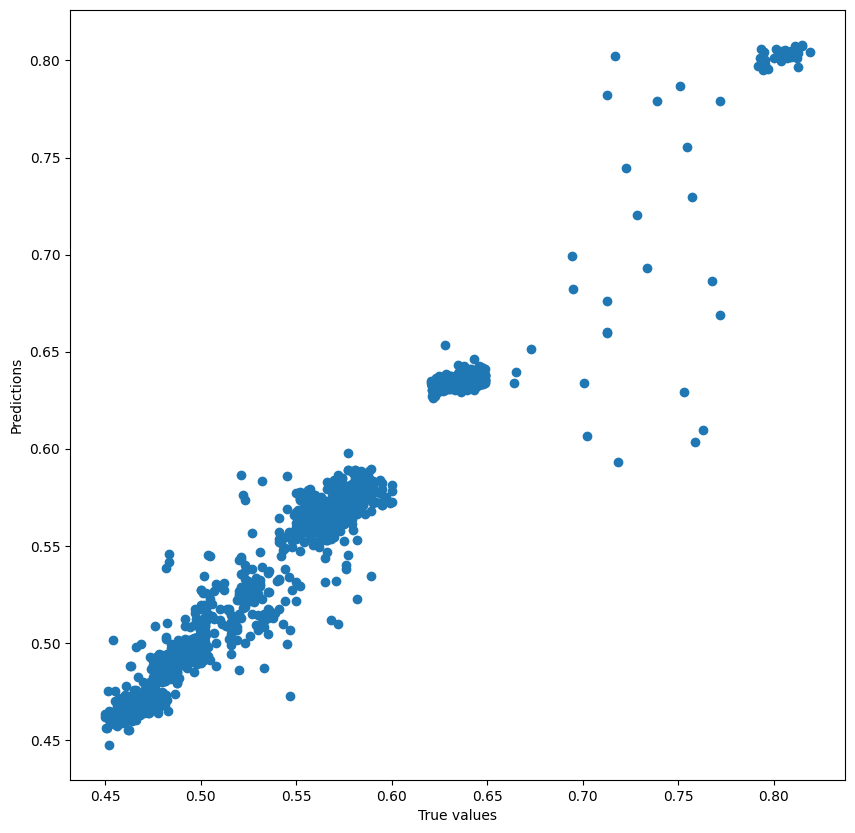

In [62]:
# Plot true vs preds

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

In [63]:
# Test the model on raw data
print("--- Test on raw data ---")

y_preds_raw = xgb.predict(X1_scaled)

rmse = np.sqrt(mean_squared_error(y_diab, y_preds_raw))
r2 = r2_score(y_diab, y_preds_raw)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))

--- Test on raw data ---
RMSE: 0.012646
R2: 0.874379


In [64]:
# Save xgb

pickle.dump(xgb, open('xgb_diab_model2_(augumented).pkl', 'wb'))

In [53]:
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))

RMSE: 0.022957
R2: 0.900174


In [40]:
X_train.shape

(9020, 15)

### Tensorflow neural net

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='swish', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='swish'),
    tf.keras.layers.Dense(16, activation='swish'),
    tf.keras.layers.Dense(16, activation='swish'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                256       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    batch_size=128,
    verbose=1
)


Epoch 1/1000


2023-02-13 13:52:02.764600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 15ms/step - loss: 0.1933 - mae: 0.4203 - val_loss: 0.0675 - val_mae: 0.2410
Epoch 2/1000
 1/71 [..............................] - ETA: 0s - loss: 0.0690 - mae: 0.2472

2023-02-13 13:52:03.830367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 10ms/step - loss: 0.0301 - mae: 0.1433 - val_loss: 0.0149 - val_mae: 0.0976
Epoch 3/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0115 - mae: 0.0853 - val_loss: 0.0086 - val_mae: 0.0726
Epoch 4/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0071 - mae: 0.0655 - val_loss: 0.0056 - val_mae: 0.0571
Epoch 5/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0048 - mae: 0.0533 - val_loss: 0.0040 - val_mae: 0.0479
Epoch 6/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0036 - mae: 0.0461 - val_loss: 0.0032 - val_mae: 0.0428
Epoch 7/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0416 - val_loss: 0.0028 - val_mae: 0.0394
Epoch 8/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0025 - mae: 0.0382 - val_loss: 0.0024 - val_mae: 0.0367
Epoch 9/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 

52/71 [====================>.........] - ETA: 0s

2023-02-13 14:03:34.249211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 0s 3ms/step
RMSE: 0.019140
R2: 0.733439


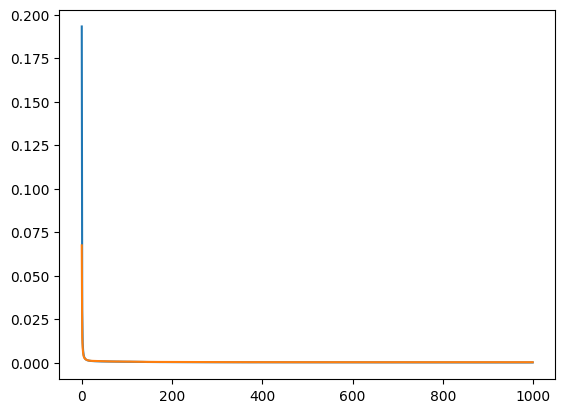

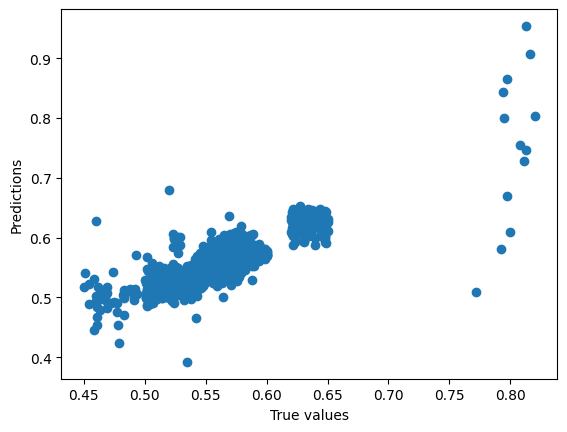

In [57]:
# Evaluate the model

model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)

# Compute metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

## 3. Coronary heart disease

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X1_scaled, y_chd, test_size=0.2, random_state=1)

If it goes so good so far, let's use XGB.

In [69]:
xgb = XGBRegressor()

parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

grid = GridSearchCV(xgb, parameters, cv=5, scoring='r2', verbose=2, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END

In [70]:
best_params_chd = {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}

xgb = XGBRegressor(**best_params_chd)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("R2: %f" % (r2))


RMSE: 0.013413
R2: 0.980655


In [71]:
# Save xgb

pickle.dump(xgb, open('xgb_chd_model.pkl', 'wb'))

# Test the wrapping class

In [19]:
x_sample = data[
    [
        'Sex', 
        'Age', 
        'Weight_p', 
        'Height_p', 
        'Bmi', 
        #'Smoke', 
        'Smoke_years', 
        'Smoke_amount_day', 
        'Chol_all', 
        'Ldl', 
        'Hdl', 
        'Sugar1', 
        'Sugar2', 
        'Sugar3', 
        'Systolic_pressure', 
        'Diastolic_pressure'
    ]].iloc[509]


In [13]:
import importlib, modelset

importlib.reload(modelset)





<module 'modelset' from '/Users/barthemius/Desktop/Machine Learning/Woś/mw-ml-study/modelset.py'>

In [14]:
mdl = modelset.ModelSet()

In [20]:
mdl.predict(x_sample)

{'chd': array([0.5140356], dtype=float32),
 'diabetes': array([0.6340497], dtype=float32),
 'obesity': array([0.58505684], dtype=float32)}